In [1]:
"""
This project was developed by Peter Chen, Rocky Duan, Pieter Abbeel for the Berkeley Deep RL Bootcamp, August 2017.
Bootcamp website with slides and lecture videos: https://sites.google.com/view/deep-rl-bootcamp/.

Code adapted from Stanford CS231N materials: http://cs231n.stanford.edu/
"""


# note to properly run this lab, you should execute all code blocks sequentially
import chainer
import chainer.functions as F
import chainer.links as L
from chainer import training
from chainer.training import extensions

from collections import namedtuple, defaultdict, deque

import numpy as np

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

## Introduction to Chainer

Chainer can be understood as Numpy plus the ability to record the computation graph of numerical operations to enable Automatic Differentiation. (Chainer actually also offers many other things; for example, a Numpy equivalent library that runs on GPU, but we will ignore them for now)

Let's illustrate how Chainer works by a simple 1D regression task.

Suppose we have observations from the following model $y = w x + b + \epsilon$ where $\epsilon \sim \mathcal{N}(0, 0.1)$ and the task is to estimate the linear model parameters $w, b$ from data.

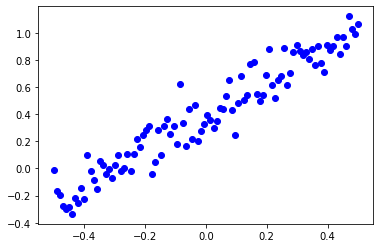

In [2]:
# first generate some observations
true_a = 1.3
true_b = 0.4
data_x = (np.arange(100) / 99.0 - .5).astype(np.float32) # Chainer assumes all the cpu computation is done in float32
data_y = (data_x * true_a + true_b + np.random.randn(*data_x.shape) * 0.1).astype(np.float32)
_ = plt.scatter(data_x, data_y, c='b')

Chainer provides an abstraction called `Link` that describe some computation and keeps track of parameters for it. For instance, a `Linear` link describes a linear map on input and keeps track of `w` and bias `b`.

In [3]:
model = L.Linear(in_size=1, out_size=1) # input is 1D data and output is also 1D data

# Chainer will randomly initialize `w` and `b` for us.
# we can take a look at their values
print("w:", model.W)
print("b:", model.b)

# model.W and model.b have type `chainer.Variable`, 
#   which is a wrapper around Numpy array
assert isinstance(model.W, chainer.Variable)

# operations that involve `chainer.Variable` will produce
#   `chainer.Variable` and this records the computation graph
var_result = model.W + 123 # some random computation
print("Operations on chainer.Variable: %s, type: %s" % (var_result, type(var_result)))

# the underlying numpy array can be accessed by `data` attribute
print("numpy arrays:", model.W.data, var_result.data)

w: variable W([[0.37915766]])
b: variable b([0.])
Operations on chainer.Variable: variable([[123.37916]]), type: <class 'chainer.variable.Variable'>
numpy arrays: [[0.37915766]] [[123.37916]]


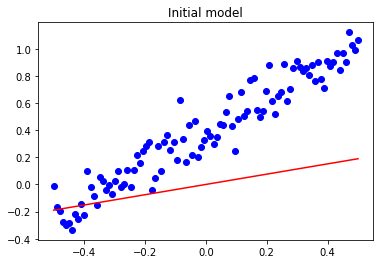

In [4]:
# A chainer link is a callable object. calling it performs the
#   forward computation. (in this case, it performs Wx + b)
model_y = model(data_x[:, None]) # chainer's link usually assumes input is [Batch Size, Input Dimension]
# `model_y` is a chainer variable so we use `.data` to access its numpy array for plotting

# we can plot the model's current fit in red. it should be terrible because we haven't trained it yet
_ = plt.plot(data_x, model_y.data[:,0], c='r')
_ = plt.scatter(data_x, data_y, c='b')
_ = plt.title("Initial model")

In [5]:
# now let's walk through how to perform forward computation
#  and use AD to get gradients

# first we clear the gradients that are stored in the model
model.cleargrads()
# as we have seen we can perform forward computation by calling the link
model_y = model(data_x[:, None])

# remember that `model_y` is a chainer variable. to operate on chainer variable
#    we will use functions from chainer.functions to operate on those objects.
loss = F.mean(F.square(model_y - data_y[:, None]))
# `loss` is a scalar chainer variable
assert isinstance(loss, chainer.Variable)
print("loss", loss)
# calculating gradients d loss /d params is as simple as
loss.backward()

# we can inspect the gradient of loss with respect to W
print("dloss/dW", model.W.grad)

loss variable(0.23293583)
dloss/dW [[-0.15101562]]


Now that we know how to calculate gradients, we can code up a simple loop to perform gradient descent to train this model:

(Hint: if you run into weird problems, maybe the state has been messed up and you can try re-runing all the code blocks from the beginning)

Itr 25 loss: variable(0.01385025)
Itr 50 loss: variable(0.01258727)
Itr 75 loss: variable(0.01205293)
Itr 100 loss: variable(0.01182625)


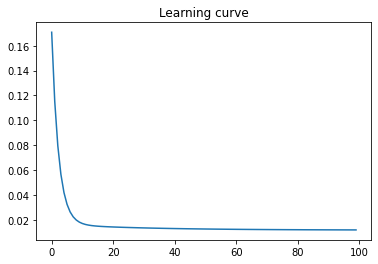

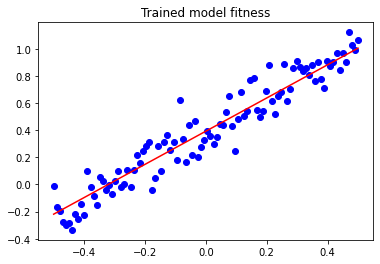

In [6]:
# now we can perform gradient descent to improve this model
model = L.Linear(in_size=1, out_size=1)
losses = []
alpha = 1e-1
for i in range(1, 101):
    model.cleargrads()
    loss = F.mean(F.square(model(data_x[:, None]) - data_y[:, None]))
    losses.append(float(loss.data))
    ## *** YOUR CODE HERE TO PERFORM GRADIENT DESCENT ***
    ## Hint: you could access gradients with model.W.grad, model.b.grad
    ## Hint2: you could write data into a parameter with model.W.data[:] = some_numpy_array
    ## Hint3: if your model doesn't learn, remember to try different learning rates
    
    loss.backward()
    model.W.data[:] -= alpha * model.W.grad
    model.b.data[:] -= alpha * model.b.grad
    
    if i % 25 == 0:
        print("Itr", i, "loss:", loss)
plt.plot(np.array(losses))
plt.title("Learning curve")
plt.figure()
plt.plot(data_x, model(data_x[:, None])[:,0].data, c='r')
plt.scatter(data_x, data_y, c='b')
_ = plt.title("Trained model fitness")


## Train your first deep model

Now we have learned the basics of Chainer. We can use it to train a deep model to classify MNIST digits. We will train a model on the MNIST dataset because the dataset is small.

First we load the data and see what the images look like:

train[i][0] is the ith image that's flattened, and has shape: (784,)
train[i][1] is the ith image's label, such as: 3


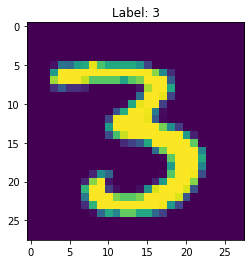

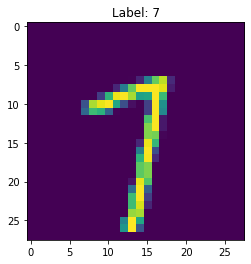

In [7]:
train, test = chainer.datasets.get_mnist()
# use train[data_point_index] to access data
print("train[i][0] is the ith image that's flattened, and has shape:", train[12][0].shape)
print("train[i][1] is the ith image's label, such as:", train[12][1])
# here we visualize two of them
plt.imshow(train[12][0].reshape([28, 28,]))
plt.title("Label: %s" % train[12][1])
plt.figure()
plt.imshow(train[42][0].reshape([28, 28,]))
_ = plt.title("Label: %s" % train[42][1])

Next we will provide some boilerplate code and train a linear classifier as an example:

In [8]:
def run(model, batchsize=16, num_epochs=2):
    
    optimizer = chainer.optimizers.Adam() # we will use chainer's Adam implementation instead of writing our own gradient based optimization
    optimizer.setup(model)
    
    stats = defaultdict(lambda: deque(maxlen=25))
    for epoch in range(num_epochs):
        train_iter = chainer.iterators.SerialIterator(train, batchsize, repeat=False, shuffle=True)
        test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)
        
        for itr, batch in enumerate(train_iter):
            xs = np.concatenate([datum[0][None, :] for datum in batch])
            ys = np.array([datum[1] for datum in batch])

            logits = model(xs)

            loss = F.softmax_cross_entropy(logits, ys)
            model.cleargrads()
            loss.backward()
            optimizer.update()
            
            # calculate stats
            stats["loss"].append(float(loss.data))
            stats["accuracy"].append(float((logits.data.argmax(1) == ys).sum() / batchsize))
            if itr % 300 == 0:
                print("; ".join("%s: %s" % (k, np.mean(vs)) for k, vs in stats.items()))

# try a simple linear model
run(L.Linear(None, 10))

loss: 2.4713282585144043; accuracy: 0.0
loss: 0.6341539108753205; accuracy: 0.8725
loss: 0.4847537291049957; accuracy: 0.8675
loss: 0.40150115251541135; accuracy: 0.885
loss: 0.34390485227108003; accuracy: 0.9
loss: 0.31751755356788636; accuracy: 0.9125
loss: 0.3187793058156967; accuracy: 0.925
loss: 0.3085054495930672; accuracy: 0.925
loss: 0.3473164162039757; accuracy: 0.8975
loss: 0.3116931712627411; accuracy: 0.92
loss: 0.31131795823574065; accuracy: 0.9075
loss: 0.3512151277065277; accuracy: 0.9075
loss: 0.2763323563337326; accuracy: 0.9175
loss: 0.3472884538769722; accuracy: 0.8975
loss: 0.33614156186580657; accuracy: 0.91
loss: 0.34231126129627226; accuracy: 0.895
loss: 0.2902482423186302; accuracy: 0.9175
loss: 0.3387493225932121; accuracy: 0.9125
loss: 0.2930757573246956; accuracy: 0.9175
loss: 0.3170761233568192; accuracy: 0.915
loss: 0.3313622322678566; accuracy: 0.935
loss: 0.2863443502783775; accuracy: 0.9175
loss: 0.3030269765853882; accuracy: 0.9325
loss: 0.2671490481495

Next we will try to improve performance by training an MLP instead. A partial implementation is provided for you to fill in:

In [9]:
class MLP(chainer.Chain):

    def __init__(self, n_units, n_out):
        super(MLP, self).__init__()
        with self.init_scope():
            # the size of the inputs to each layer will be inferred
            self.l1 = L.Linear(None, n_units)  # n_in -> n_units
            self.l2 = L.Linear(None, n_units)  # n_units -> n_units
            self.l3 = L.Linear(None, n_out)  # n_units -> n_out

    def __call__(self, x):
        # *** YOUR CODE HERE TO BUILD AN MLP W/ self.l1, self.l2, self.l3 ***
        # 
        # Hint: you should make use of non-linearities / activation functions
        #     https://docs.chainer.org/en/stable/reference/functions.html#activation-functions
        x = self.l1(x)
        x = F.relu(x)
        x = self.l2(x)
        x = F.relu(x)
        return self.l3(x)
run(MLP(200, 10))

loss: 2.356867790222168; accuracy: 0.125
loss: 0.3041664284467697; accuracy: 0.91
loss: 0.2560737437009811; accuracy: 0.9225
loss: 0.2556815505027771; accuracy: 0.93
loss: 0.14607934921979904; accuracy: 0.9675
loss: 0.14694190949201583; accuracy: 0.955
loss: 0.18226105093955994; accuracy: 0.94
loss: 0.13680297642946243; accuracy: 0.9575
loss: 0.17502264976501464; accuracy: 0.945
loss: 0.08661870151758194; accuracy: 0.9675
loss: 0.16991642206907273; accuracy: 0.9525
loss: 0.10347384124994279; accuracy: 0.96
loss: 0.09878161638975143; accuracy: 0.9675
loss: 0.10436892986297608; accuracy: 0.97
loss: 0.09904782235622406; accuracy: 0.98
loss: 0.08272776961326599; accuracy: 0.975
loss: 0.09225750982761383; accuracy: 0.9675
loss: 0.11718792736530304; accuracy: 0.97
loss: 0.083660888671875; accuracy: 0.97
loss: 0.0929272410273552; accuracy: 0.9725
loss: 0.13707173377275467; accuracy: 0.95
loss: 0.108749041557312; accuracy: 0.9675
loss: 0.06156569689512253; accuracy: 0.9775
loss: 0.058599852323

Next you should try to implement logging test loss and see if the model is overfitting.

In [10]:
def better_run(model, batchsize=16, num_epochs=3):

    optimizer = chainer.optimizers.Adam() # we will use chainer's Adam implementation instead of writing our own gradient based optimization
    optimizer.setup(model)
    
    stats = defaultdict(lambda: deque(maxlen=25))
    for epoch in range(num_epochs):
        train_iter = chainer.iterators.SerialIterator(train, batchsize, repeat=False, shuffle=True)
        for itr, batch in enumerate(train_iter):
            xs = np.concatenate([datum[0][None, :] for datum in batch])
            ys = np.array([datum[1] for datum in batch])

            logits = model(xs)

            loss = F.softmax_cross_entropy(logits, ys)
            model.cleargrads()
            loss.backward()
            optimizer.update()
            
            # calculate stats
            stats["loss"].append(float(loss.data))
            stats["accuracy"].append(float((logits.data.argmax(1) == ys).sum() / batchsize))
            if itr % 300 == 0:
                test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)
                # *** YOUR CODE implement logging of stats on test set ***
                for t_itr, test_batch in enumerate(test_iter):
                    xs = np.concatenate([datum[0][None, :] for datum in test_batch])
                    ys = np.array([datum[1] for datum in test_batch])
        
                    logits = model(xs)
        
                    test_loss = F.softmax_cross_entropy(logits, ys)
                    
                    # calculate stats
                    stats["test_loss"].append(float(test_loss.data))
                    stats["test_accuracy"].append(float((logits.data.argmax(1) == ys).sum() / batchsize))
                
                print("; ".join("%s: %s" % (k, np.mean(vs)) for k, vs in stats.items()))

better_run(MLP(200, 10))

loss: 2.2457852363586426; accuracy: 0.125; test_loss: 2.317279787063599; test_accuracy: 0.15
loss: 0.3806398099660873; accuracy: 0.895; test_loss: 0.45223143339157107; test_accuracy: 0.8525
loss: 0.25765431225299834; accuracy: 0.9425; test_loss: 0.3317156755924225; test_accuracy: 0.8825
loss: 0.230503653883934; accuracy: 0.9425; test_loss: 0.3913677707314491; test_accuracy: 0.87
loss: 0.17178152233362198; accuracy: 0.94; test_loss: 0.25153699308633803; test_accuracy: 0.9225
loss: 0.1642038631439209; accuracy: 0.9425; test_loss: 0.22572011590003968; test_accuracy: 0.935
loss: 0.18389862924814224; accuracy: 0.9375; test_loss: 0.25047394514083865; test_accuracy: 0.92
loss: 0.1523059767484665; accuracy: 0.95; test_loss: 0.2622045522928238; test_accuracy: 0.915
loss: 0.14189887881278992; accuracy: 0.9625; test_loss: 0.2771165597438812; test_accuracy: 0.9125
loss: 0.15508511483669282; accuracy: 0.96; test_loss: 0.22459879875183106; test_accuracy: 0.9325
loss: 0.10014647722244263; accuracy: 0

Try different variants!

- Does using a ConvNet improve performance (reduce overfitting?)
- Try changing the learning rate and observe the effect
- Does the model train if you give it correlated gradients? (consecutively sample many batches of "1", then many batches of "2", ... etc

# A Conv Model (added by me)


In [26]:


class ConvMLP(chainer.Chain):

    def __init__(self, n_units, n_out):
        super(ConvMLP, self).__init__()
        with self.init_scope():
            # the size of the inputs to each layer will be inferred
            self.conv1 = L.Convolution2D(None, out_channels=32, ksize=3, stride=1)
            self.conv2 = L.Convolution2D(None, out_channels=16, ksize=3, stride=1)
            self.l1 = L.Linear(None, n_units)  # n_units -> n_units
            self.l2 = L.Linear(None, n_out)  # n_units -> n_out

    def __call__(self, x):
        # *** YOUR CODE HERE TO BUILD AN MLP W/ self.l1, self.l2, self.l3 ***
        # 
        # Hint: you should make use of non-linearities / activation functions
        #     https://docs.chainer.org/en/stable/reference/functions.html#activation-functions
        h = self.conv1(x)
        h = F.relu(h)
        #h = F.max_pooling_2d(h, 2, 2) # I get an error when using max_pool, but it could have inhanced the performance 
        h = self.conv2(h)
        h = F.relu(h)
        #h = F.max_pooling_2d(h, 2, 2)
        h = self.l1(h)
        h = F.relu(h)
        return self.l2(h)


# Updated run function 
To be able to run the new model we need to reshape the input to be used by a Conv2D


In [27]:
def better_run2D(model, batchsize=16, num_epochs=2):

    optimizer = chainer.optimizers.Adam() # we will use chainer's Adam implementation instead of writing our own gradient based optimization
    optimizer.setup(model)
    
    stats = defaultdict(lambda: deque(maxlen=25))
    for epoch in range(num_epochs):
        train_iter = chainer.iterators.SerialIterator(train, batchsize, repeat=False, shuffle=True)
        for itr, batch in enumerate(train_iter):
            xs = np.concatenate([datum[0][None, :].reshape(1, 1, 28,28) for datum in batch])
            ys = np.array([datum[1] for datum in batch])

            logits = model(xs)

            loss = F.softmax_cross_entropy(logits, ys)
            model.cleargrads()
            loss.backward()
            optimizer.update()
            
            # calculate stats
            stats["loss"].append(float(loss.data))
            stats["accuracy"].append(float((logits.data.argmax(1) == ys).sum() / batchsize))
            if itr % 300 == 0:
                test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)
                # *** YOUR CODE implement logging of stats on test set ***
                for t_itr, test_batch in enumerate(test_iter):
                    xs = np.concatenate([datum[0][None, :].reshape(1, 1, 28,28) for datum in test_batch])
                    ys = np.array([datum[1] for datum in test_batch])
        
                    logits = model(xs)
        
                    test_loss = F.softmax_cross_entropy(logits, ys)
                    
                    # calculate stats
                    stats["test_loss"].append(float(test_loss.data))
                    stats["test_accuracy"].append(float((logits.data.argmax(1) == ys).sum() / batchsize))
                
                print("; ".join("%s: %s" % (k, np.mean(vs)) for k, vs in stats.items()))
                
better_run2D(ConvMLP(200, 10))

loss: 2.3664894104003906; accuracy: 0.125; test_loss: 2.3629766798019407; test_accuracy: 0.13
loss: 0.1949221283197403; accuracy: 0.9325; test_loss: 0.21797408103942872; test_accuracy: 0.9275
loss: 0.1688108742237091; accuracy: 0.9475; test_loss: 0.20390983700752258; test_accuracy: 0.93
loss: 0.16982434511184694; accuracy: 0.955; test_loss: 0.16846567451953887; test_accuracy: 0.94
loss: 0.1157213020324707; accuracy: 0.9625; test_loss: 0.12875898003578187; test_accuracy: 0.96
loss: 0.07475020885467529; accuracy: 0.9775; test_loss: 0.08715917438268661; test_accuracy: 0.975
loss: 0.05151321589946747; accuracy: 0.985; test_loss: 0.13052728712558748; test_accuracy: 0.9525
loss: 0.08588266551494599; accuracy: 0.9775; test_loss: 0.09736463785171509; test_accuracy: 0.965
loss: 0.07786070764064788; accuracy: 0.97; test_loss: 0.05988629043102264; test_accuracy: 0.98
loss: 0.049625532627105715; accuracy: 0.985; test_loss: 0.1331951439380646; test_accuracy: 0.96
loss: 0.07918362379074097; accuracy